### Package Dependencies

In [19]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Connect to MongoDB

In [2]:
conn = 'mongodb://localhost:27018'
client = pymongo.MongoClient(conn)

### Pull Data

In [6]:
# db = client.eliteprospects

# metadata = db.meta_data
# player_stats = db.player_data
# inter_stats = db.international_data
# playoff_stats = db.playoffs_data

# meta = pd.DataFrame(list(metadata.find()))
# players = pd.DataFrame(list(player_stats.find()))
# inter = pd.DataFrame(list(inter_stats.find()))
# playoffs = pd.DataFrame(list(playoff_stats.find()))

### Write/Read CSV

In [11]:
# meta.to_csv('meta.csv')
# players.to_csv('players.csv')
# inter.to_csv('international.csv')
# playoffs.to_csv('playoffs.csv')

meta = pd.read_csv('~/Analytics/ScoutingWithAI/Misc/meta.csv')
players = pd.read_csv('~/Analytics/ScoutingWithAI/Misc/players.csv')
inter = pd.read_csv('~/Analytics/ScoutingWithAI/Notebooks/international.csv')

### International

In [16]:
inter.sample(10)

,Unnamed: 0,_id,ep_id,team,league,int_gp,int_g,int_a,int_pim,int_pm
122,122,5e0a6c6cb796e999afd8c00b,199564,Czech Republic U20 (all),International-Jr,7,1,3,2,0
1895,1895,5e0a7960b796e999afd95627,337772,Canada White U17,WHC-17,6,0,1,4,0
37,37,5e0a6ba2b796e999afd8b73c,8610,Czech Republic,WC,9,0,0,8,4
3650,3650,5e0a86afb796e999afd9ec89,11598,Slovakia U20,WJC-20,6,1,0,4,-4
286,286,5e0a6d32b796e999afd8c95a,547,Sweden U18 (all),International-Jr,14,2,3,43,0
2197,2197,5e0a7bc0b796e999afd9719f,18350,Slovakia U18,WJC-18,7,1,1,2,1
1346,1346,5e0a75ccb796e999afd92cc4,201615,Czech Republic U17 (all),International-Jr,6,3,4,4,1
2462,2462,5e0a7dbab796e999afd98874,372919,Finland U18,WJC-18,7,0,2,2,3
1326,1326,5e0a7594b796e999afd92a37,26388,Canada U18,WJC-18,7,2,1,14,0
1300,1300,5e0a7577b796e999afd92902,10442,Canada,WC,7,2,2,0,5


In [15]:
inter = inter.replace({'-': 0, '': 0, np.nan: 0})
inter[['int_gp', 'int_g', 'int_a', 'int_pim', 'int_pm']] = inter[['int_gp', 'int_g', 'int_a', 'int_pim', 'int_pm']].astype(int)

In [17]:
inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4162 entries, 0 to 4161
Data columns (total 10 columns):
Unnamed: 0    4162 non-null int64
_id           4162 non-null object
ep_id         4162 non-null int64
team          4162 non-null object
league        4162 non-null object
int_gp        4162 non-null int64
int_g         4162 non-null int64
int_a         4162 non-null int64
int_pim       4162 non-null int64
int_pm        4162 non-null int64
dtypes: int64(7), object(3)
memory usage: 325.3+ KB


In [18]:
inter_grouped = round(inter.groupby('ep_id').agg({
    'int_gp': 'sum', 
    'int_g': 'sum', 
    'int_a': 'sum', 
    'int_pim': 'sum',
    'int_pm': 'mean'
}))
inter_grouped.sample(20)

,int_gp,int_g,int_a,int_pim,int_pm
ep_id,,,,,
348076,5,0,1,4,3.0
8397,3,0,0,24,0.0
277056,89,12,32,48,1.0
9359,19,4,2,16,-1.0
279031,5,0,0,2,0.0
247053,5,1,4,0,0.0
9477,43,2,11,36,2.0
70435,85,5,9,30,-0.0
214934,73,15,16,28,1.0


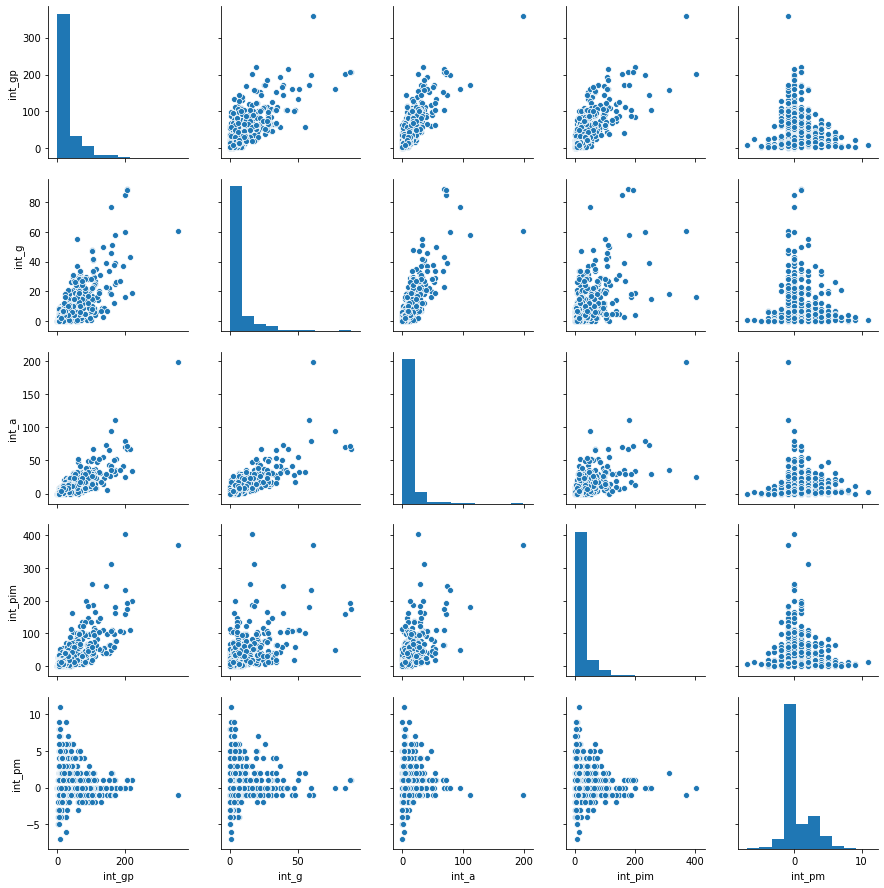

In [20]:
sns.pairplot(inter_grouped[['int_gp', 'int_g', 'int_a', 'int_pim', 'int_pm']])

In [ ]:
playoffs.sample(20)

## Wrangling

### Get the age of each player for each season

In [ ]:
# Set ep_id as an integer
players['ep_id'] = players['ep_id'].astype(int)

# Likewise for meta
meta['ep_id'] = meta['ep_id'].astype(int)

# In case of dubplicates, drop them
meta = meta.drop_duplicates()
players = players.drop_duplicates()

In [ ]:
# Set aside each players birthday
birthdays = meta[['ep_id', 'date_of_birth']]

# Merge the birthdays with each player row in the players table
players = pd.merge(players, birthdays, on = 'ep_id', how = 'left')

In [ ]:
# Extract the end of season date for each yyyy-yy season variable
players['end_of_season'] = '20' + players['season'].str.extract(r'-(\d{2})') + '-04-05'

In [ ]:
# Convert date_of_birth and end_of_season to pandas datetime
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['end_of_season'] = pd.to_datetime(players['end_of_season'])

# Subtract end_of_season from date_of_birth to get the age of each player at the end of each season
players['age'] = players['end_of_season'] - players['date_of_birth']

# Convert the pandas timedelta object to integer years
players['age'] = round(players['age'].dt.days / 365).astype(int)

# Set aside current date
players['current_date'] = pd.to_datetime('today')

# Subtract players birth date from the current date to get the current age
players['current_age'] = players['current_date'] - players['date_of_birth']

# Convert the pandas timedelta to integer years
players['current_age'] = round(players['current_age'].dt.days / 365).astype(int)

In [ ]:
# Subset the players table to only include players who are over 25 at the time of running
players = players[players['current_age'] >= 25]

### Manage +/-

In [ ]:
# Deal with mis-typed values in the plus_minus column
players['plus_minus'] = players['plus_minus'].replace('--6', '-6')

# Impute 0 inplace of - in plus_minus (Fortunately, plus_minus is gaussian and 0 is the mean)
players.replace('-', 0, inplace=True)
players['plus_minus'] = players['plus_minus'].astype(int)

### Reshape quantitative data

In [ ]:
ids = players['ep_id'].unique()

types = {
    'assists': 'int64',
    'games_played': 'int64',
    'goals': 'int64',
    'penalty_min': 'int64',
    'plus_minus': 'int64',
    'age': 'object'
}

new_df = pd.DataFrame()

for id in ids:
        
    df = players[players['ep_id'] == id].drop_duplicates()
    df = df.astype(types)
    
    # Have to groupby each players age to account for in-season trades
    df = df.groupby(['age', 'ep_id']).agg({
        'games_played': 'sum', 
        'goals': 'sum', 
        'assists': 'sum', 
        'penalty_min': 'sum',
        'plus_minus': 'mean'
    }).reset_index()    
    
    # Pivot the data frame to form a single row vector for each player
    df = df.pivot('ep_id', 'age')
    
    # Column Labels    
    # Manage the pandas multiindex to re-label each column for each stat and age
    df.columns = [''.join(str(col)) for col in df.columns]
    
    # Rename column labels for clarity
    labels = []
    
    for col in df:
    
        label = re.findall(r"'(.+)'", col)
        stat = re.findall(r',\s(\d{2})', col)
    
        labels.append(label[0] + '_' + stat[0])
        
    df.columns = labels    
    
    # Append each row of player data to the last
    new_df = pd.concat([new_df, df], axis=0, sort=False)

### Reshape qualitative

In [ ]:
ids = players['ep_id'].unique()

qual_df = pd.DataFrame()

for id in ids:
    
    df = players[players['ep_id'] == id].reset_index().sort_values('age')
    df = df.drop(['index', '_id'], 1).drop_duplicates()
    
    ages = []
    teams = []
    leagues = []
    age_test = []

    high_gp = 0

    for row in df.iterrows():    

        if row[1]['age'] not in age_test:

            age_test.append(row[1]['age'])

            age = row[1]['age']
            team = row[1]['team']
            league = row[1]['league']

            high_gp = int(row[1]['games_played'])

            ages.append(age)
            teams.append(team)
            leagues.append(league)

        elif row[1]['age'] in age_test:

            if int(row[1]['games_played']) > high_gp:

                age = row[1]['age']
                team = row[1]['team']
                league = row[1]['league']

                high_gp = int(row[1]['games_played'])

                ages = ages[:-1]
                teams = teams[:-1]
                leagues = leagues[:-1]

                ages.append(age)
                teams.append(team)
                leagues.append(league)

    test_df = pd.DataFrame(zip(ages, teams, leagues), columns=['age', 'team', 'league'])

    test_df['ep_id'] = row[1]['ep_id']

    test_df = test_df.pivot('ep_id', 'age')

    test_df.columns = [''.join(str(col)) for col in test_df.columns]

    # Rename column labels for clarity
    labels = []

    for col in test_df:

        label = re.findall(r"'(.+)'", col)
        stat = re.findall(r',\s(\d{2})', col)

        labels.append(label[0] + '_' + stat[0])

    test_df.columns = labels
    
    qual_df = pd.concat([qual_df, test_df], axis=0, sort=False)

### Merge qualitative and quantitative dataframes

In [ ]:
combined = pd.merge(new_df, qual_df, on='ep_id', how='left').reset_index()

### Combine Meta and Combined dataframes

In [ ]:
main = pd.merge(meta, combined, on = 'ep_id', how = 'left')
    
main = main.reset_index()
main = round(main.drop(['_id', 'index'], 1))

### Save and inspect data

In [ ]:
#main.to_csv('main.csv')